In [1]:
import sys
sys.path.insert(0,'/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sys.path.insert(0,'../qnmfits')
from qnmfits_combined import *
from read_waveforms import *
from qnmfits import *

The `sxs` package doesn't have functionality to download data from the [Ext-CCE waveform catalog](https://data.black-holes.org/waveforms/extcce_catalog.html). For convenience we provide a `cce` class which downloads CCE data at the recommended extraction radius and creates an [`AsymptoticBondiData`](https://scri.readthedocs.io/en/latest/tutorial_abd.html) object.

In [4]:
import cce

In [5]:
# Initialize the cce class
cce = cce.cce()

# We specify the ID of the simulation we want to use. This will download the 
# simulation if it is not already on your computer, and store it in 
# qnmfits/data
abd = cce.load(2)

In [6]:
# We also store useful metadata in the abd object:

# Using metadata
Mf_md = abd.metadata['remnant_mass']
chif_md = np.linalg.norm(abd.metadata['remnant_dimensionless_spin'])

# Using abd object
Mf = abd.bondi_rest_mass()[-1]
chi_vec = abd.bondi_dimensionless_spin()[-1]
chif = np.linalg.norm(chi_vec)

In [7]:
print(Mf_md, Mf, np.subtract(Mf_md, Mf))
print(chif_md, chif, np.subtract(chif_md, chif))

0.945511134141 0.9455111101928358 2.394816411843692e-08
0.746428620809 0.7464286222463634 -1.437363450484952e-09


In [8]:
# The cce class provides a function to easily convert the AsymptoticBondiData
# object to a WaveformModes object
h_eliot = cce.abd_to_h(abd)
h = MT_to_WM(2*abd.sigma.bar)

# Rescale the time so that the peak of the waveform is at t=0
h_eliot.t -= h_eliot.max_norm_time()
h.t -= h.max_norm_time()

Text(0, 0.5, '$\\mathrm{Re}[h_{22}]$')

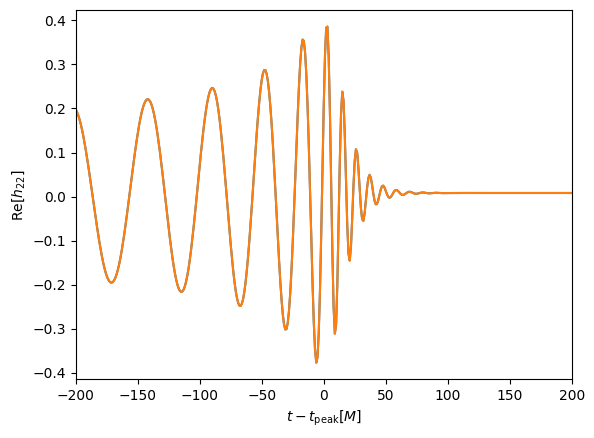

In [9]:
fig, ax = plt.subplots()

ax.plot(h_eliot.t, np.real(h_eliot.data[:, h_eliot.index(2,2)]))
ax.plot(h.t, np.real(h.data[:, h.index(2,2)]))

ax.set_xlim(-200, 200)

ax.set_xlabel(r'$t - t_\mathrm{peak} [M]$')
ax.set_ylabel(r'$\mathrm{Re}[h_{22}]$')

### Perform a seven overtone fit to the $h_{22}$ mode at a range of different ringdown start times:

In [10]:
spherical_mode = (2,2)
qnms = [(2,2,n,1) for n in range(7+1)]

t0_array = np.linspace(-25, 25, 51)
mismatch_list = []

for t0 in t0_array:
    best_fit = ringdown_fit(
        h,
        spherical_mode,
        qnms,
        Mf=Mf,
        chif=chif,
        t0=t0,
        t0_method='closest'
    )
    mismatch_list.append(best_fit['mismatch'])

In [11]:
mode_dict = {}
for k in range(0,8):
    mode_dict[(2, 2, k, 1)] = None
    
t0_array = np.linspace(-25, 25, 51)
mismatch_list_l = []
for t0 in t0_array:
    W_shifted = h.copy()[np.argmin(abs(h.t - t0)):np.argmin(abs(h.t - 90))+1,:]
    W_shifted.t = W_shifted.t - W_shifted.t[0]
    res_mode_dict = fit_W_modes(W_shifted, chif, Mf, mode_dict, t_0=0., t_ref=0.)
    Q = qnm_modes_as(chif, Mf, res_mode_dict, W_shifted, dest=None, t_0=0., t_ref=0.)
    mismatch = waveform_mismatch(W_shifted, Q, 0., mode=(2,2))    
    mismatch_list_l.append(mismatch)


Text(0, 0.5, 'Mismatch, $\\mathcal{M}$')

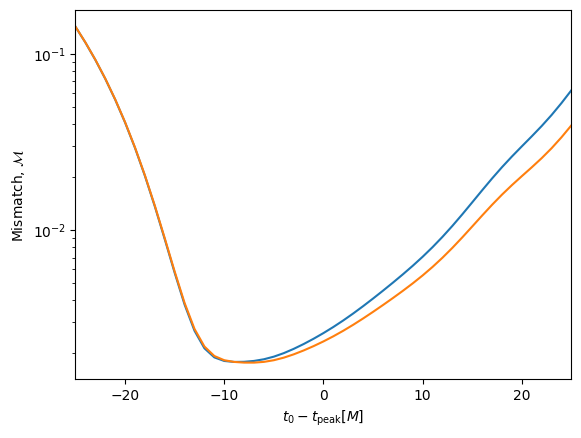

In [12]:
fig, ax = plt.subplots()
ax.set_yscale('log')

ax.plot(t0_array, mismatch_list)
ax.plot(t0_array, mismatch_list_l)

ax.set_xlim(t0_array[0], t0_array[-1])

ax.set_xlabel(r'$t_0 - t_\mathrm{peak} [M]$')
ax.set_ylabel(r'Mismatch, $\mathcal{M}$')

### Map to the superrest frame

The `cce` class also has a convenience function to transform the waveform to the superrest frame of the remnant black hole, and caches the data.

In [13]:
abd_prime = cce.map_to_superrest(abd, t0=300)
h_prime_eliot = cce.abd_to_h(abd_prime)
h_prime = to_superrest_frame(abd, t_0=300., padding_time=250.)

Text(0, 0.5, '$\\mathrm{Re}[h_{22}]$')

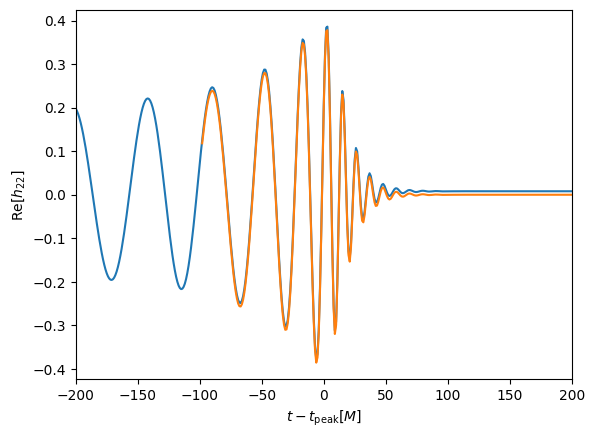

In [14]:
fig, ax = plt.subplots()

ax.plot(h.t, np.real(h.data[:, h.index(2,2)]))
ax.plot(h_prime_eliot.t, np.real(h_prime_eliot.data[:, h_prime_eliot.index(2,2)]))

ax.set_xlim(-200, 200)

ax.set_xlabel(r'$t - t_\mathrm{peak} [M]$')
ax.set_ylabel(r'$\mathrm{Re}[h_{22}]$')

Text(0, 0.5, '$\\mathrm{Re}[h_{22}]$')

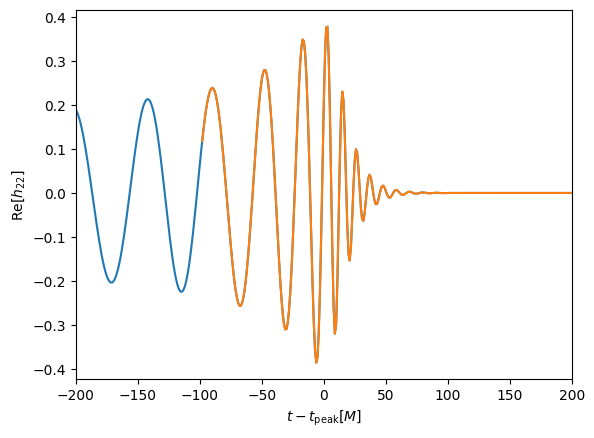

In [15]:
fig, ax = plt.subplots()

ax.plot(h_prime.t, np.real(h_prime.data[:, h_prime.index(2,2)]))
ax.plot(h_prime_eliot.t, np.real(h_prime_eliot.data[:, h_prime_eliot.index(2,2)]))

ax.set_xlim(-200, 200)

ax.set_xlabel(r'$t - t_\mathrm{peak} [M]$')
ax.set_ylabel(r'$\mathrm{Re}[h_{22}]$')

In [16]:
superrest_mismatch_list = []

for t0 in t0_array:
    best_fit = ringdown_fit(
        h_prime_eliot,
        spherical_mode,
        qnms,
        Mf=Mf,
        chif=chif,
        t0=t0,
        t0_method='closest'
    )
    superrest_mismatch_list.append(best_fit['mismatch'])

In [17]:
superrest_mismatch_list_l = []

for t0 in t0_array:
    W_shifted = h_prime.copy()[np.argmin(abs(h_prime.t - t0)):np.argmin(abs(h_prime.t - 90))+1,:]
    W_shifted.t = W_shifted.t - W_shifted.t[0]
    res_mode_dict = fit_W_modes(W_shifted, chif, Mf, mode_dict, t_0=0., t_ref=0.)
    Q = qnm_modes_as(chif, Mf, res_mode_dict, W_shifted, dest=None, t_0=0., t_ref=0.)
    mismatch = waveform_mismatch(W_shifted, Q, 0., mode=(2,2))    
    superrest_mismatch_list_l.append(mismatch)


Text(0, 0.5, 'Mismatch, $\\mathcal{M}$')

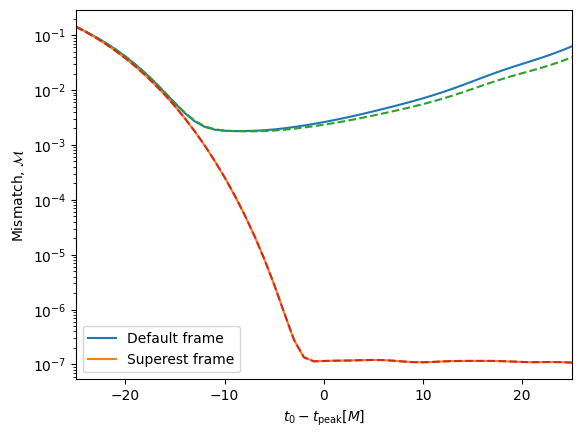

In [18]:
fig, ax = plt.subplots()
ax.set_yscale('log')

ax.plot(t0_array, mismatch_list, label='Default frame')
ax.plot(t0_array, superrest_mismatch_list, label='Superest frame')

ax.plot(t0_array, mismatch_list_l, '--')
ax.plot(t0_array, superrest_mismatch_list_l, '--')

ax.set_xlim(t0_array[0], t0_array[-1])

ax.legend()

ax.set_xlabel(r'$t_0 - t_\mathrm{peak} [M]$')
ax.set_ylabel(r'Mismatch, $\mathcal{M}$')